In [1]:
%pylab notebook
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('/home/qyli/oPDF2')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [2]:
def unify_data(inputdata, untype = 'MM'):
    dmin = np.min(inputdata, axis = 0)
    dmax = np.max(inputdata, axis = 0)
    
    if untype == 'MM':
        return (inputdata - dmin) / (dmax - dmin)

In [2]:
fileCM = '../proxy/cluster/G3X-CM-masscomplete-ALL.txt'
filefit = '../proxy/cluster/GXsub_DM_fitmc_rcin200_100000_TMP.txt'
dataCM = np.loadtxt(fileCM)
datafit = np.loadtxt(filefit)
import oPDFplus as opd
mmtrue = datafit[:,0] / dataCM[:,2] * 1e15
cctrue = datafit[:,1] / dataCM[:,6]
loc = opd.sigma3sel(np.log10(mmtrue),np.log10(cctrue))

318
312
311
310
310


In [13]:
#calculate the oob error
target = np.loadtxt('../proxy/cluster/GXsub_DM_InL_rcin200_100000_TMP.txt')[loc]
(1e5 / 200)**2 / (np.var(target))
print(1 -  (1e5 / 200)**2  / np.var(target))

0.06085201157239806


In [3]:
target = np.loadtxt('../proxy/cluster/GXsub_DM_InL_rcin200_100000_TMP.txt')[loc]

maind = np.loadtxt('../proxy/GadgetX_DS_main')

JeansE = np.loadtxt('../proxy/JeansE_DM_lnL_rcin200_n100000_bin20_boot200')[loc]

#select feathers
# mar = maind[:,6]
# maind[mar<0,6] = np.min(mar[mar>0])
# maind[:,6] = np.log10(maind[:,6]) #make mar to be log
maind = maind[loc,1:]
# maind = unify_data(maind)

fbest = np.append(maind, JeansE.reshape(310,1), axis = 1)
print(fbest.shape)

(310, 28)


In [4]:
# fbest = fbest[id_rex]
# target = target[id_rex]
print(fbest.shape)
Nsam = fbest.shape[0]

indices = np.arange(Nsam)
predt = np.zeros((Nsam))
time = np.zeros(Nsam)
oob = np.zeros(50)
for j in range(50):
    x_train,x_test,y_train,y_test,idx_train,idx_test = train_test_split(fbest, target, indices, test_size=0.3, random_state=j)
    forest = RandomForestRegressor(n_estimators=400, min_samples_leaf = 5, random_state=j,  oob_score = True)
    forest.fit(x_train, y_train)
    oob[j] = forest.oob_score_
    predt[idx_test] += forest.predict(x_test)
    time[idx_test] += 1
print(np.mean(oob))    


(310, 28)
0.7967482918282422


In [7]:
np.savetxt('../proxy/RF_predt_DSJeans', predt/time)

<IPython.core.display.Javascript object>


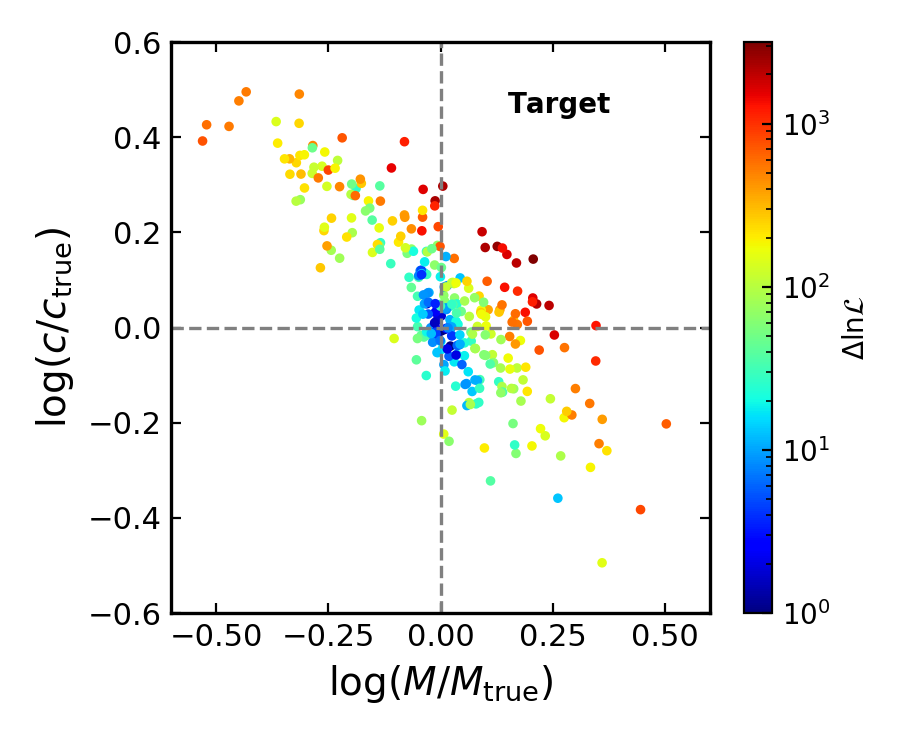

In [7]:
from matplotlib.patches import Patch
import oPDFplus as opd
def main():
    mx = mmtrue[loc]
    cy = cctrue[loc]

    dataInL = predt/time

    plt.figure(figsize = (4.5,3.7))
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.tick_params(top = 'on', right = 'on', which='both')
    plt.scatter(np.log10(mx),np.log10(cy),c = target, s = 6, norm=matplotlib.colors.LogNorm(),
        cmap = 'jet',vmin = 1, vmax = 10**3.5)
    cbar = plt.colorbar()
    cbar.set_label(r'$\Delta \ln \mathcal{L}$')

    def sigplot(loc0,lin):
        m_m0 = np.log10(mx[loc0])
        c_c0 = np.log10(cy[loc0])
        covmc = np.cov(m_m0,c_c0)
        print("cc is ",covmc[0,1] / covmc[0,0]**0.5  / covmc[1,1]**0.5)
        xs,ys,zs,siglevel = opd.sigma2dis(m_m0,c_c0,prisig = False)
        plt.contour(np.log10(xs),np.log10(ys),zs,levels = siglevel,linestyles = [lin],colors = 'k')
	
# 	loc0 = np.where(dataInL < 10**3)[0]
# 	sigplot(loc0,lin = ':')
# 	print(loc0.shape)
# 	# loc0 = np.where(dataInL < 2.5)[0]
# 	# sigplot(loc0,lin = '-.')
# 	# print(loc0.shape)
# 	loc0 = np.where(dataInL < 10**2)[0]
# 	sigplot(loc0,lin = '--')
# 	print(loc0.shape)
# 	loc0 = np.where(dataInL < 10**1)[0]
# 	sigplot(loc0,lin = '-')
# 	print(loc0.shape)

# 	patch = Patch(edgecolor='k', linestyle = ':', label=r'$\Delta \ln \mathcal{L} < 10^3$',facecolor='white')
# 	# patch1 = Patch(edgecolor='k', linestyle = '--', label=r'log$\Delta \ln L < 2.5$',facecolor='white')
# 	patch2 = Patch(edgecolor='k', linestyle = '--', label=r'$\Delta \ln \mathcal{L} < 10^2$',facecolor='white')
# 	patch3 = Patch(edgecolor='k', linestyle = '-', label=r'$\Delta \ln \mathcal{L} < 10^1$',facecolor='white')
# 	legend2 = plt.legend(handles=[patch,patch2,patch3],fontsize = 'small',loc = 1)

    plt.tick_params(labelsize = 11)
    plt.axvline(0, color = 'grey', lw = 1.2, ls = '--')
    plt.axhline(0, color = 'grey', lw = 1.2, ls = '--')
    plt.xlim(-0.6,0.6)
    plt.ylim(-0.6,0.6)
    plt.xlabel(r'$\log (M/M_{\rm true})$',fontsize = 14)
    plt.ylabel(r'$\log (c/c_{\rm true})$',fontsize = 14)
    # plt.loglog()

    bwith = 1.2 #边框宽度设置为2
    ax = plt.gca()#获取边框
    ax.spines['bottom'].set_linewidth(bwith)
    ax.spines['left'].set_linewidth(bwith)
    ax.spines['top'].set_linewidth(bwith)
    ax.spines['right'].set_linewidth(bwith)

    plt.text(0.15,0.45,'Target', fontweight = 'semibold')

    plt.tight_layout()
    plt.savefig('./figs/Pred.pdf')
    plt.show()

main()

<IPython.core.display.Javascript object>


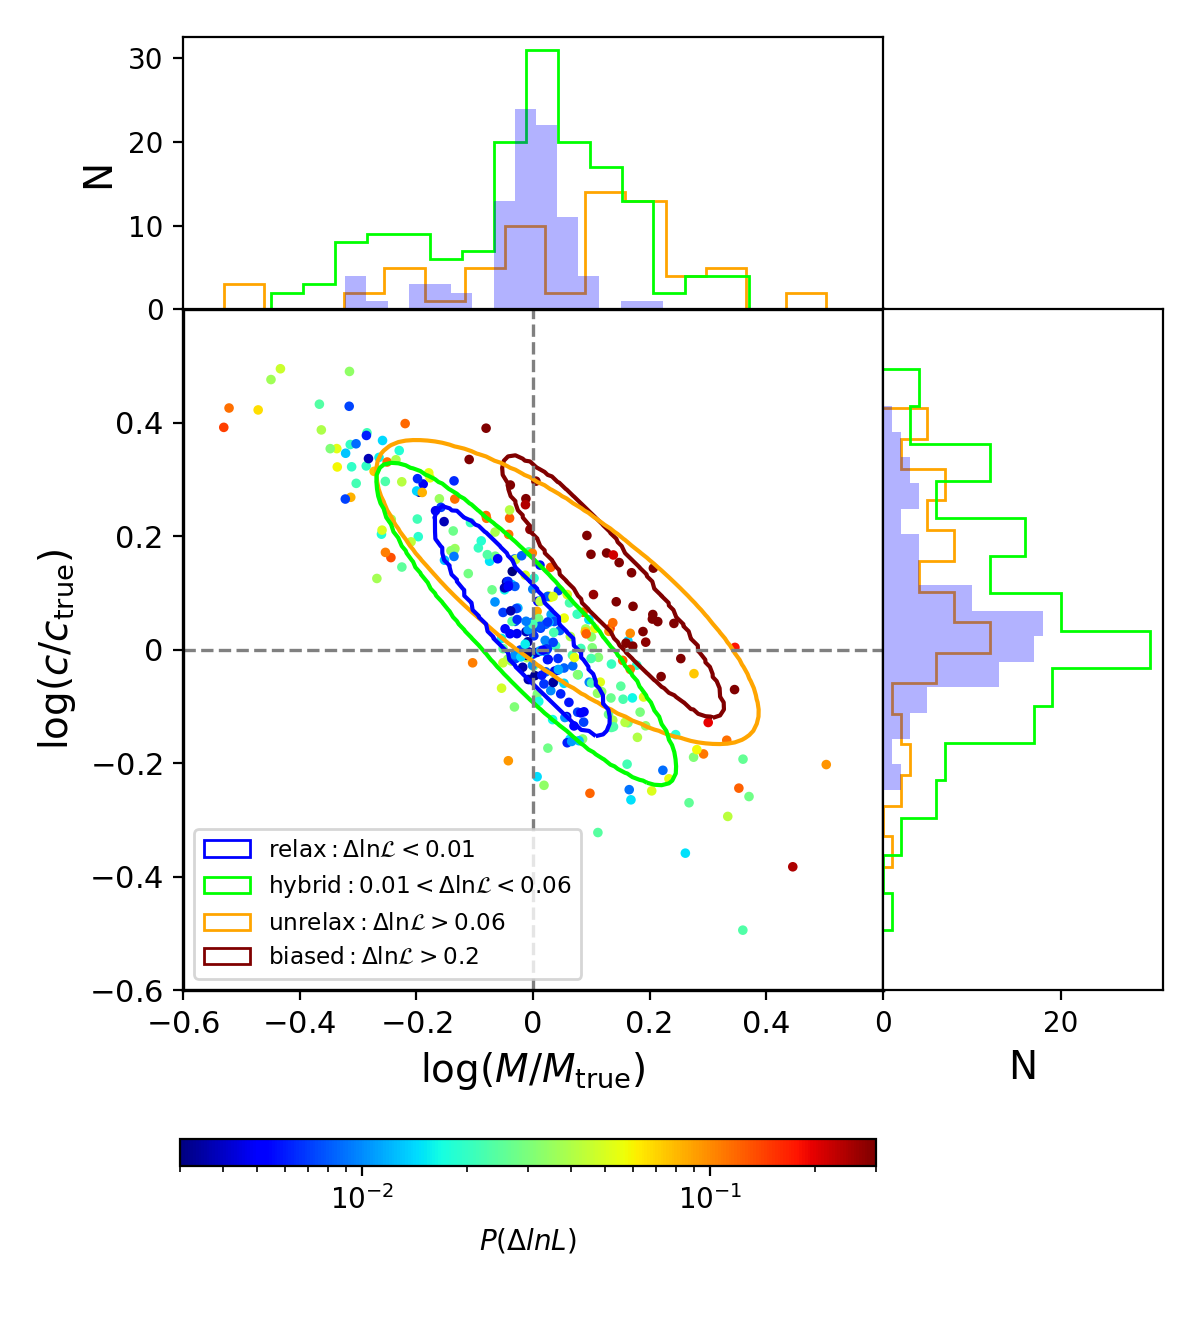

cc is  -0.9323239936602248
sigmaM, sigmaC in log10 0.12328047972117152 0.15140138638694559
mean M,c in log10 0.13749668063306336 0.1105975152372931
mean M 1.4270252255171159
(29,)
cc is  -0.7942596063396069
sigmaM, sigmaC in log10 0.21596402721740096 0.1764160126934073
mean M,c in log10 0.0590503405760635 0.10178902888480092
mean M 1.2774117227719983
(66,)
cc is  -0.8990238431842807
sigmaM, sigmaC in log10 0.16942355400778844 0.18666240718178229
mean M,c in log10 -0.011475853461437362 0.04542864196022368
mean M 1.0466552163750085
(155,)
cc is  -0.9090734234428073
sigmaM, sigmaC in log10 0.09731558583292398 0.13101097937228587
mean M,c in log10 -0.020591463284290342 0.05062746385252878
mean M 0.9755598555240361
(89,)


In [7]:
predmean = predt/time

plt.figure(figsize = (6,6.7))

ax1 = plt.subplot2grid((9,7),(2,0),colspan = 5,rowspan = 5)
ax10 = plt.subplot2grid((9,7),(0,0),colspan = 5,rowspan = 2)
ax20 = plt.subplot2grid((9,7),(2,5),colspan = 2,rowspan = 5)
ax30 = plt.subplot2grid((9,7),(7,0),colspan = 5,rowspan = 2)

mx = np.log10(mmtrue[loc])
cy = np.log10(cctrue[loc])

sc1 = ax1.scatter(mx,cy,s = 6,c = predmean,cmap = 'jet',norm=matplotlib.colors.LogNorm(),
           vmax = 0.3, vmin = 3e-3)
cax = plt.axes([0.15, 0.13, 0.58, 0.02])
plt.colorbar(sc1, cax = cax, label = r'$P(\Delta lnL)$', orientation="horizontal")


def sigplot(loc0,col):
    m_m0 = mx[loc0]
    c_c0 = cy[loc0]
    covmc = np.cov(m_m0,c_c0)
    print("cc is ",covmc[0,1] / covmc[0,0]**0.5  / covmc[1,1]**0.5)
    print('sigmaM, sigmaC in log10',covmc[0,0]**0.5,covmc[1,1]**0.5)
    print('mean M,c in log10', np.mean(m_m0), np.mean(c_c0))
    print('mean M', np.mean(10**m_m0))
    
    xs,ys,zs,siglevel = opd.sigma2dis(m_m0,c_c0,prisig = False)
    ax1.contour(np.log10(xs),np.log10(ys),zs,levels = siglevel,linestyles = ['-'],colors = col)

# loc0 = np.where(predmean > 0.3)[0]
# # sigplot(loc0,lin = ':')
# print(loc0.shape)

id_biased = np.where(predmean > 0.2)[0]
# ax10.hist(mx[id_biased], range = (-0.6,0.6), bins = 20, color = 'maroon', 
#           histtype = 'step',alpha = 1, density =False)
# ax20.hist(cy[id_biased], range = (-0.6,0.6), bins = 20, color = 'maroon', histtype = 'step',alpha = 1,
#           density = False, orientation='horizontal')
sigplot(id_biased,col = 'maroon')
print(id_biased.shape)

# id_unrelax = np.where((predmean <= 2e-1) & (predmean > 5e-2))[0]
id_unrelax = np.where(predmean > 0.06)[0]
ax10.hist(mx[id_unrelax],  bins = 15, color = 'orange', 
          histtype = 'step',alpha = 1, density =False)
ax20.hist(cy[id_unrelax], bins = 15, color = 'orange', histtype = 'step',alpha = 1,
          density = False, orientation='horizontal')
sigplot(id_unrelax,col = 'orange')
print(id_unrelax.shape)

id_hybrid = np.where((predmean <= 6e-2) & (predmean > 0.01))[0]
ax10.hist(mx[id_hybrid],  bins = 15, color = 'lime', 
          histtype = 'step',alpha = 1, density =False)
ax20.hist(cy[id_hybrid], bins = 15, color = 'lime', histtype = 'step', alpha = 1,
          density = False, orientation='horizontal')
sigplot(id_hybrid,col = 'lime')
print(id_hybrid.shape)

id_relax = np.where(predmean <= 0.01)[0]
ax10.hist(mx[id_relax], bins = 15, color = 'b', 
          histtype = 'bar',alpha = 0.3, density = False)
ax20.hist(cy[id_relax], bins = 15, color = 'b', histtype = 'bar',alpha = 0.3,
          density = False, orientation='horizontal')
sigplot(id_relax,col = 'b')
print(id_relax.shape)

#-------------------------------------------------------
from matplotlib.patches import Patch
patch_relax = Patch(edgecolor='blue', label=r'$\mathrm{relax}: \Delta \ln \mathcal{L} < 0.01$',facecolor='white')
patch_hybrid = Patch(edgecolor='lime', label=r'$\mathrm{hybrid}: 0.01 < \Delta \ln \mathcal{L} < 0.06$',facecolor='white')
patch_unrelax = Patch(edgecolor='orange', label=r'$\mathrm{unrelax}: \Delta \ln \mathcal{L} > 0.06$',facecolor='white')
patch_bias = Patch(edgecolor='maroon', label=r'$\mathrm{biased}: \Delta \ln \mathcal{L} > 0.2$',facecolor='white')
legend2 = ax1.legend(handles=[patch_relax,patch_hybrid,patch_unrelax,patch_bias],fontsize = 'small',loc = 3)
    
ax1.tick_params(labelsize = 11)
ax1.axvline(0, color = 'grey', lw = 1.2, ls = '--')
ax1.axhline(0, color = 'grey', lw = 1.2, ls = '--')
ax1.set_xlim(-0.6,0.6)
ax1.set_ylim(-0.6,0.6)
ax1.set_xlabel(r'$\log (M/M_{\rm true})$',fontsize = 14)
ax1.set_ylabel(r'$\log (c/c_{\rm true})$',fontsize = 14)

ax30.axis('off')

ax10.set_xlim(-0.6,0.6)
ax10.set_xticks([])
ax10.set_ylabel('N', fontsize = 14)
ax20.set_ylim(-0.6,0.6)
ax20.set_yticks([])
ax20.set_xlabel('N',fontsize = 14)

ax1.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4])
ax1.set_xticklabels(['$-$0.6','$-$0.4','$-$0.2',0,0.2,0.4])
ax1.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4])
ax1.set_yticklabels(['$-$0.6','$-$0.4','$-$0.2',0,0.2,0.4])

bwith = 1.2 #边框宽度设置为2
# ax = plt.gca()#获取边框
ax1.spines['bottom'].set_linewidth(bwith)
ax1.spines['left'].set_linewidth(bwith)
ax1.spines['top'].set_linewidth(bwith)
ax1.spines['right'].set_linewidth(bwith)

# plt.title('DS+Jeans')
plt.tight_layout()
plt.subplots_adjust(wspace =0 ,hspace = 0)
plt.savefig('./figs/Pred.pdf')

<IPython.core.display.Javascript object>


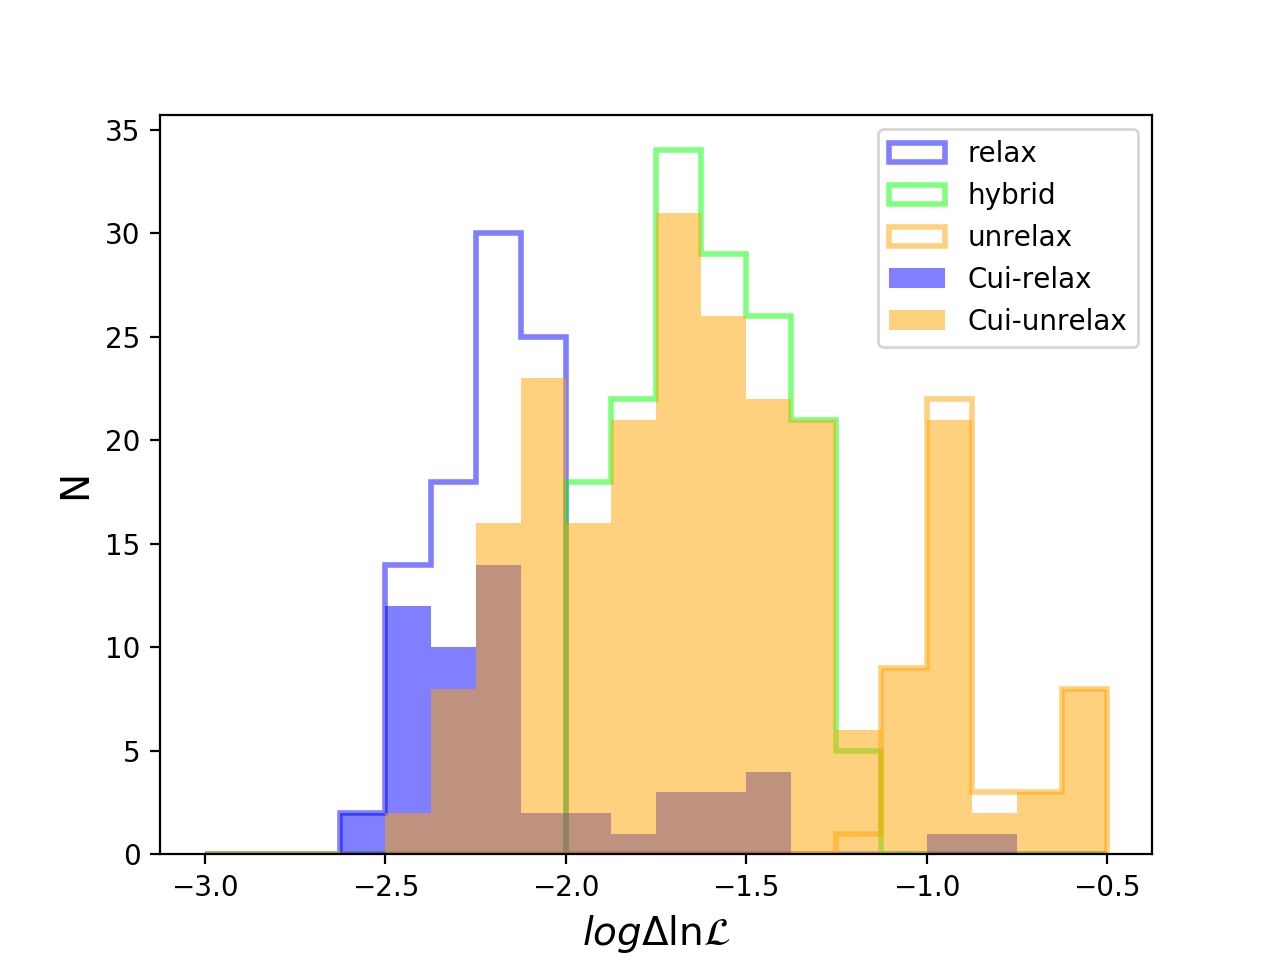

(89,) (155,) (66,)
(86,) (94,) (130,)


Text(0.5, 0, '$log \\Delta \\ln \\mathcal{L}$')

In [21]:
#comparison
chi2DS = np.loadtxt('../proxy/GadgetX_DS_main')[loc,4]
DS = np.loadtxt('../proxy/cluster/DS-G3X_Mass_snap_128-center-cluster.txt')[loc,2]

plt.figure()
plt.hist(np.log10(predmean[id_relax]), range = (-3,-0.5),bins = 20, color = 'b', label = 'relax', histtype = 'step',
          alpha = 0.5, lw = 2)
plt.hist(np.log10(predmean[id_hybrid]), range = (-3,-0.5),bins = 20, color = 'lime', label = 'hybrid',histtype = 'step',
          alpha = 0.5, lw = 2)
plt.hist(np.log10(predmean[id_unrelax]), range = (-3,-0.5),bins = 20, color = 'orange', label = 'unrelax',
          histtype = 'step', lw = 2, alpha = 0.5)
print(id_relax.shape, id_hybrid.shape, id_unrelax.shape)

id_cui_relax = np.where(DS == 1)[0]
id_cui_unrelax = np.where(DS == 0)[0]

plt.hist(np.log10(predmean[id_cui_relax]), range = (-3,-0.5),bins = 20, color = 'b', label = 'Cui-relax',
          alpha = 0.5)
plt.hist(np.log10(predmean[id_cui_unrelax]), range = (-3,-0.5),bins = 20, color = 'orange', label = 'Cui-unrelax',
          alpha = 0.5)

id_hag_relax = np.where(chi2DS > 1.03)[0]
id_hag_hybrid = np.where((chi2DS <= 1.03) & (chi2DS >= 0.619))[0]
id_hag_unrelax = np.where(chi2DS < 0.619)[0]
print(id_hag_relax.shape,id_hag_hybrid.shape,id_hag_unrelax.shape)

# plt.hist(np.log10(predmean[id_hag_relax]), range = (-3,-0.5),bins = 20, color = 'b', label = 'Hag-relax',
#           alpha = 0.3,lw = 2,)
# plt.hist(np.log10(predmean[id_hag_hybrid]), range = (-3,-0.5),bins = 20, color = 'lime', label = 'Hag-hybrid',
#           alpha = 0.3,lw = 2,)
# plt.hist(np.log10(predmean[id_hag_unrelax]), range = (-3,-0.5),bins = 20, color = 'orange', label = 'Hag-unrelax',
#           alpha = 0.3,lw = 2)

plt.legend()

plt.ylabel('N', fontsize = 14)
plt.xlabel(r'$log \Delta \ln \mathcal{L}$', fontsize = 14)